In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterstats import zonal_stats
import numpy as np
import osmnx as ox
import networkx as nx
import os
import datetime as dt
import glob
import matplotlib.pyplot as plt

In [3]:

def find_raster_files(root_dir, file_extension='xx'):
    raster_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(file_extension):
                raster_files.append(os.path.join(root, file))
    return raster_files

def merge_rasters_with_mask(raster_files):
    src_files_to_mosaic = [rasterio.open(raster) for raster in raster_files]
    
    # Merge data
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Update the metadata with the merged data properties
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0]  # Update to match the number of layers in the mosaic
    })
    
    for src in src_files_to_mosaic:
        src.close()
    
    return mosaic, out_trans, out_meta

def compute_zonal_stats(polygons, raster_data, affine, nodata_value=None):
    stats = zonal_stats(polygons, raster_data, affine=affine, stats=['sum'], nodata=nodata_value)
    return stats

In [4]:
def shade_weights_to_graph(osmid,date,timesteps,graph_path):
    # Load graph: 
    graph_orig = ox.load_graphml(f'{graph_path}')
        
    print('Loaded graph')

    nodes, edges = ox.graph_to_gdfs(graph_orig)

    print('Got nodes, edges gdf')

    # Initialize an empty dictionary
    shade_weights = {}



    for time in timesteps:
        root_directory = f"../results/output/{osmid}/tree_shade/"
        timestr_extension = f'{date}_{time}_LST.tif'
        print(timestr_extension)
        raster_files = find_raster_files(root_directory, timestr_extension)
        print(f'found {len(raster_files)}files to merge')

        mosaic, out_trans, out_meta = merge_rasters_with_mask(raster_files)

        # Ensure polygons are in the same CRS as the raster
        raster_crs = out_meta['crs']
        # if poly.crs != raster_crs:
        #     poly = poly.to_crs(raster_crs)

        # Update metadata for the virtual raster
        out_meta.update({
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans
        })

        # print('Merge successful; Server is sweating a little. Stats are next')

        nodata_value = out_meta.get('nodata', None)

        print(f'Done merging {time}!')

        if edges.crs != raster_crs:
            edges = edges.to_crs(raster_crs)

        # Assuming 'mosaic' is your merged raster data
        stats = compute_zonal_stats(edges, mosaic[0], affine=out_trans, nodata_value=nodata_value)

        # # Add statistics to polygon dataset
        for stat_type in ['sum']:
            edges[f'shade_{time}_{stat_type}'] = [s[stat_type] for s in stats]

        edges[f'shade_weight_{time}'] = edges[f'shade_{time}_sum'] / edges['length']

        print(f'Calculated weight for {time}!')
    
        # Loop through the list of times and add to the dictionary
        # for time in times:
        key = f'shade_weight_{time}'
        value = getattr(edges, key)
        shade_weights[key] = value

    edges.geometry = edges.geometry.to_crs(28992)

    shade_weights['crs']=edges.crs

    graph_new = ox.graph_from_gdfs(nodes, edges, graph_attrs=shade_weights)

    print(f'Created new graph')

    return graph_new



osmid = 271110
date = '240620'
times = ['1000','1100','1200','1300','1400','1500','1600','1700','1800']

# times[2]
graph_path = '../data/raw_data/graph/Amst_walknbike_network.graphml'
edge = shade_weights_to_graph(osmid,date,times,graph_path)


Loaded graph
Got nodes, edges gdf
240620_1000_LST.tif
found 173files to merge
Done merging 1000!
Calculated weight for 1000!
240620_1100_LST.tif
found 173files to merge
Done merging 1100!
Calculated weight for 1100!
240620_1200_LST.tif
found 173files to merge
Done merging 1200!
Calculated weight for 1200!
240620_1300_LST.tif
found 173files to merge
Done merging 1300!
Calculated weight for 1300!
240620_1400_LST.tif
found 173files to merge
Done merging 1400!
Calculated weight for 1400!
240620_1500_LST.tif
found 173files to merge
Done merging 1500!
Calculated weight for 1500!
240620_1600_LST.tif
found 173files to merge
Done merging 1600!
Calculated weight for 1600!
240620_1700_LST.tif
found 173files to merge
Done merging 1700!
Calculated weight for 1700!
240620_1800_LST.tif
found 173files to merge
Done merging 1800!
Calculated weight for 1800!
Created new graph


In [1]:
ox.save_graphml(edge,'../results/output/240808_AMS_walknbike_shade_weight_240620.graphml')

NameError: name 'ox' is not defined

In [4]:
for i, (u, v, data) in enumerate(graph.edges(data=True)):
    if i < 10:
        print(f"{data}")
    else:
        break

{'osmid': [38297120, 7372610, 38297119], 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': False, 'length': 42.497, 'bridge': 'yes', 'name': ['Oude Spiegelstraat', 'Joes Kloppenburgbrug'], 'geometry': <LINESTRING (121029.232 487038.331, 121020.753 487039.357, 120996.73 487041....>, 'shade_1200_sum': '56.099998474121094', 'shade_weight_1200': '1.3200931471426476'}
{'osmid': 7372614, 'highway': 'residential', 'maxspeed': '30', 'oneway': True, 'reversed': False, 'length': 225.577, 'name': 'Singel', 'geometry': <LINESTRING (121029.232 487038.331, 121053.617 487235.731, 121058.429 487262...>, 'shade_1200_sum': '9.0', 'shade_weight_1200': '0.039897684604370126'}
{'osmid': 562720340, 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 62.907, 'name': 'Singel', 'geometry': <LINESTRING (121029.232 487038.331, 121027.731 487026.969, 121021.004 486975...>, 'shade_1200_sum': '5.0', 'shade_weight_1200': '0.07948241054254694'}
{'osmid': 474

In [6]:


for u, v, data in graph.edges(data=True):
    # Specify the edge attributes you want to convert to float
    for time in times:
        keys_to_convert = [f'shade_weight_{time}'] 

        for key in keys_to_convert:
            # Check if the key exists and is a string
            if key in data and isinstance(data[key], str):
                try:
                    # Convert to float and update the attribute
                    data[key] = float(data[key])
                except ValueError:
                    print(f"Could not convert {data[key]} for edge ({u}, {v})")

times = ['1000','1100','1200','1300','1400','1500','1600','1700','1800']

In [2]:
graph = ox.load_graphml('../results/output/240808_AMS_walknbike_shade_weight_240620.graphml')

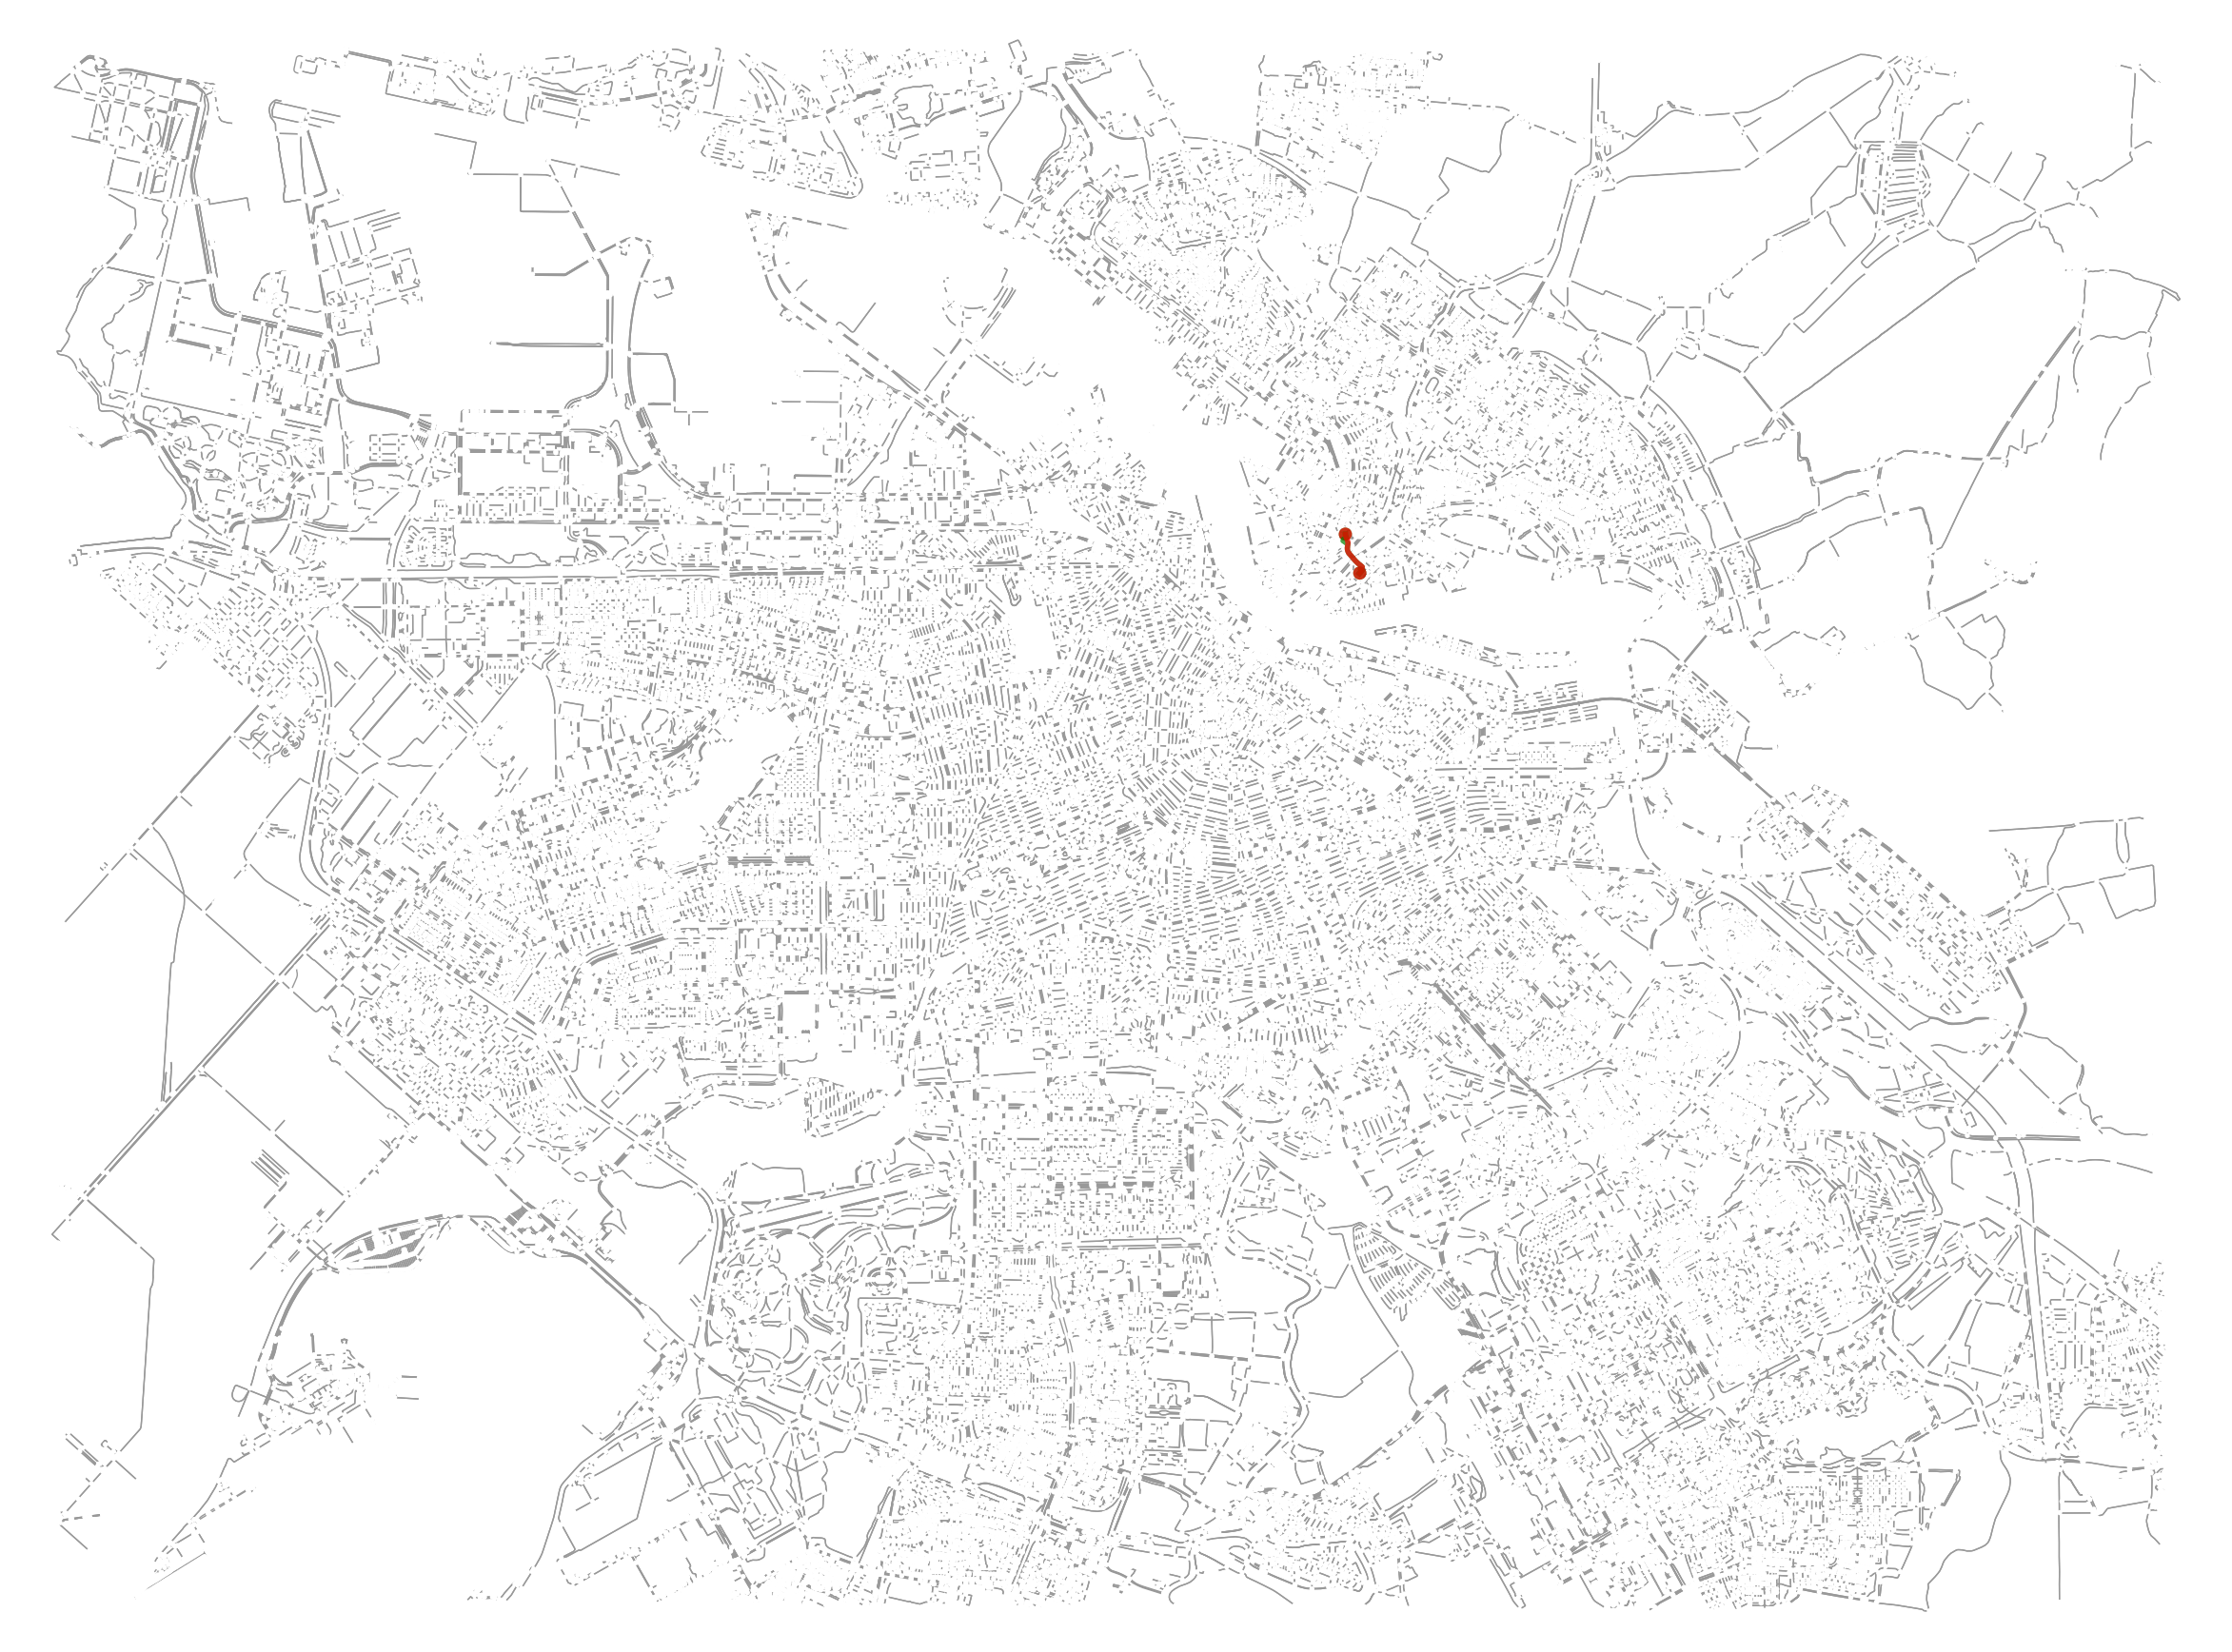

(488680.2863819578, 489083.12857580656)

In [9]:
# Assuming 'graph' is already created using osmnx and 'ox' is imported as shown

# Define origin and destination nodes
origin_node_2 = 11184651937
destination_node_2 = 11274852194

# Calculate routes
shady_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='shade_weight_1200')
shortest_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='length')

# Margin for bounding box
margin = 0.01  # Small margin in degrees

# Get positions of the origin and destination nodes
origin_point = (graph.nodes[origin_node_2]['y'], graph.nodes[origin_node_2]['x'])
destination_point = (graph.nodes[destination_node_2]['y'], graph.nodes[destination_node_2]['x'])

# Calculate bounding box based on origin and destination coordinates
minx = min(origin_point[1], destination_point[1]) - margin
maxx = max(origin_point[1], destination_point[1]) + margin
miny = min(origin_point[0], destination_point[0]) - margin
maxy = max(origin_point[0], destination_point[0]) + margin

# Create plot
fig, ax = plt.subplots(figsize=(30, 30))

# # Plot the graph
ox.plot_graph(graph, ax=ax, show=False, close=False)
routes = [shady_route,shortest_route]
# # Plot routes
# ox.plot_graph_route(graph, shady_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='r', ax=ax)
# ox.plot_graph_route(graph, shortest_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='g', ax=ax)

ox.plot_graph_routes(graph, routes, route_colors=['g','r'], route_linewidth=2, route_alpha=0.7, ax=ax)

# Set limits for the bounding box
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# # Show plot
# plt.show()
